# 注意
    SVC模型有两个非常重要的参数C与gamma。其中 C是惩罚系数，即对误差的宽容度。C越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。gamma是选择RBF函数作为kernel后，该函数自带的一个参数。隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度。

人脸识别（Face Recognition），是基于人的脸部特征信息进行身份识别的一种生物识别技术。用摄像机或摄像头采集含有人脸的图像或视频流，并自动在图像中检测和跟踪人脸，进而对检测到的人脸进行脸部的一系列相关技术，通常也叫做人像识别、面部识别。

由于往往图像的维度较高，把二维的图像先灰度化，转化为一通道的图像，之后再把它首尾相接转化为一个列向量，假设图像大小是20像素*20像素的，那么这个向量就是400维。采用传统的机器学习分类算法在面对大量的特征时，往往抓不到主要特征，从而训练得到的模型的分类性能较低。

一种经典的解决人脸识别问题的算法是特征脸法（Eigenface），本质上其实就是PCA降维。特征脸方法利用主成分分析进行降维和特征提取。主成分分析是一种应用十分广泛的数据降维技术，该方法选择与原数据协方差矩阵前几个最大特征值对应的特征向量构成一组基，以达到最佳表征原数据的目的。因为由主分量分析提取的特征向量返回成图像时，看上去仍像人脸，所以这些特征向量被称为“特征脸”。

本案例中，我们将使用Labeled Faces in the Wild网站的All images aligned with funneling数据集，利用SVM分类算法来进行降维后的图片的分类

# 数据源 

我们使用一份包含1288个样本的关于一些著名政要照片的数据集，需要通过在sklearn.datasets包中的fetch_lfw_people函数获取。

# 数据探索与预处理 

In [3]:
# 首先，使用sklearn.datasets包中的fetch_lfw_people()函数将数据加载到内存中：
from time import time
import pylab as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [4]:
# 选取不少于70张面布图像的政要
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [5]:
# 获取样本数，图片的尺寸信息
n_samples, h, w = lfw_people.images.shape

In [8]:
n_samples, h, w

(1288, 50, 37)

In [10]:
lfw_people.data.shape

(1288, 1850)

In [11]:
np.random.seed(42)
#获取所有样本的特征2维数组
X = lfw_people.data
n_features = X.shape[1]

In [12]:
#政要的类别数组
y = lfw_people.target
#政要的类别所对应的名字数组
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [15]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [13]:
print("数据集信息:")
print("样本数量: %d" % n_samples)
print("降维前每张图片的特征个数: %d" % n_features)
print("政要类别个数（不同的人的个数）: %d" % n_classes)

数据集信息:
样本数量: 1288
降维前每张图片的特征个数: 1850
政要类别个数（不同的人的个数）: 7


## 通过初步观察，发现所有的变量中不存在缺失值（missing value）。我们可以验证数据中确实没有缺失值。 

In [16]:
value_ravel = X.ravel()
print('数据中的缺失值个数：',len(value_ravel[value_ravel==np.nan]))

数据中的缺失值个数： 0


## 处理不平衡数据 

由于这是一个分类问题，我们需要查看数据集中的数据是否平衡。又以下代码可以得到每个类别有多少个样本：

In [17]:
print('数据中的各类别样本分布：')
print(pd.Series(y).value_counts().sort_index())

数据中的各类别样本分布：
0     77
1    236
2    121
3    530
4    109
5     71
6    144
dtype: int64


我们可以看出，数据中的属于不同类别的样本的分布是不平衡的。因此，我们需要对不平衡数据进行处理。这里我们选择过抽样的方法来使数据变得平衡。首先我们需要安装imbalanced-learn包来对不平衡数据进行处理

In [18]:
# 过采样
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X, y = ros.fit_sample(X, y)

In [20]:
RandomOverSampler?

In [19]:
print(pd.Series(y).value_counts().sort_index())

0    530
1    530
2    530
3    530
4    530
5    530
6    530
dtype: int64


## 数据标准化

由于图像的每个维度的值都是[0,255]内的灰度值，属于同一量纲，因此不需要进行数据标准化。

# PCA降维处理

由于原始图像的维度很高，有1850个特征，不利于用于训练分类模型。因此，我们先对原始数据进行PCA降维处理。将数据切分成80%的数据作为训练集，20%的数据作为测试集

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
len(X_train)

2968

我们将1850维特征降低到n_components维，这里我们选用n_components=150维，也就是选用150个主成分

In [24]:
# PCA?

In [23]:
n_components = 150
print('从训练集的 %d 张脸中抽取最重要的 %d 个特征脸，也就是将数据降低到 %d 维' % (X_train.shape[0] , n_components,n_components))
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
print('降维后的150个主成分的累积方差贡献率：%.2f ' % round(sum(pca.explained_variance_ratio_),2))
#将训练集和测试集的除去目标变量的数据通过训练好的PCA模型进行降维
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

从训练集的 2968 张脸中抽取最重要的 150 个特征脸，也就是将数据降低到 150 维
降维后的150个主成分的累积方差贡献率：0.96 


# 模型训练

为了实现人脸识别，也就是识别出图像中的人物是谁。在经过降维处理的数据上，我们将使用sklearn.svm包中的SVC类来实现来构建基于SVM的人脸识别模型。 SVC 有两个主要的参数可以设置：核函数参数 kernel 和约束惩罚参数C。核函数参数 kernel的常用取值及其对应含义如下：
- "linear"：线性核函数
- "poly"：多项式核函数
- "rbf"：径向基核函数
- "sigmoid"： sigmoid核函数

SVC模型有两个非常重要的参数C与gamma。其中 C是惩罚系数，即对误差的宽容度。C越高，说明越不能容忍出现误差,容易过拟合。C越小，容易欠拟合。gamma是选择RBF函数作为kernel后，该函数自带的一个参数。隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持向量越少，gamma值越小，支持向量越多。支持向量的个数影响训练与预测的速度。

我们使用sklearn.grid_search包中的GridSearchCV类对模型进行构造。

In [25]:
param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Grid search找到的最佳分类模型为:")
print(clf.best_estimator_)

C:\Apps\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid search找到的最佳分类模型为:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


# 模型性能评估

首先，使用predict()函数得到上一节训练的支持向量机模型在测试集合上的预测结果，然后使用 sklearn.metrics中的classification_report()和confusion_matrix()函数对模型的性能进行评估。

In [27]:
y_predict = clf.predict(X_test_pca)
print(classification_report(y_test, y_predict, target_names=target_names))
print(confusion_matrix(y_test, y_predict, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00       101
     Colin Powell       0.97      0.96      0.96       116
  Donald Rumsfeld       1.00      1.00      1.00       105
    George W Bush       0.96      0.96      0.96       112
Gerhard Schroeder       1.00      1.00      1.00       101
      Hugo Chavez       0.99      1.00      1.00       105
       Tony Blair       1.00      1.00      1.00       102

         accuracy                           0.99       742
        macro avg       0.99      0.99      0.99       742
     weighted avg       0.99      0.99      0.99       742

[[101   0   0   0   0   0   0]
 [  0 111   0   4   0   1   0]
 [  0   0 105   0   0   0   0]
 [  0   4   0 108   0   0   0]
 [  0   0   0   0 101   0   0]
 [  0   0   0   0   0 105   0]
 [  0   0   0   0   0   0 102]]


上述混淆矩阵中对角线的元素表示模型正确预测数，对角元素之和表示模型整体预测正确的样本数。

现在，让我们来通过这个来计算模型在测试集中的预测正确率。

In [28]:
print("Accuracy:", accuracy_score(y_test, y_predict))

Accuracy: 0.9878706199460916


可见，训练得到的模型在原始集的20%的测试样本中，预测的正确率（Accuaray）为98.78%。

# 特征脸示例及预测结果可视化 

在得到训练得到的模型性能之后，我们可以查看之前通过降维提取到的特征脸：

In [31]:
eigenfaces

array([[[-5.74009307e-03, -6.71694009e-03, -7.67954765e-03, ...,
         -1.13458680e-02, -1.07585015e-02, -1.02467863e-02],
        [-6.58450229e-03, -7.42323278e-03, -8.96332227e-03, ...,
         -1.25432890e-02, -1.18909609e-02, -1.16668278e-02],
        [-7.85662141e-03, -8.75113159e-03, -1.07742781e-02, ...,
         -1.35524273e-02, -1.21979108e-02, -1.17480662e-02],
        ...,
        [ 2.37057405e-03,  1.99216604e-03, -9.69202432e-04, ...,
         -2.06133649e-02, -1.87882483e-02, -1.65987723e-02],
        [ 1.98473386e-03,  5.51449892e-04, -1.20171800e-03, ...,
         -2.04571150e-02, -1.79785881e-02, -1.59646198e-02],
        [ 1.94696477e-03, -2.86856230e-04, -1.94957142e-03, ...,
         -2.00112127e-02, -1.78575143e-02, -1.51903797e-02]],

       [[ 2.11869646e-02,  1.98537428e-02,  2.10582800e-02, ...,
         -2.15679947e-02, -2.20098216e-02, -2.17666868e-02],
        [ 2.15858817e-02,  2.08292063e-02,  2.34841593e-02, ...,
         -2.20515467e-02, -2.26523913e

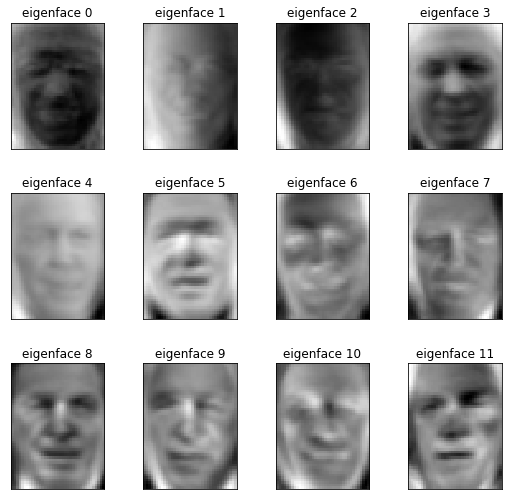

In [29]:
# 绘图函数，默认将画出待画图像数组中图像的前3*4=12个图像
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

另外，我们可以直观地表示用训练好的分类模型进行人脸识别的结果，前12个全部预测正确：

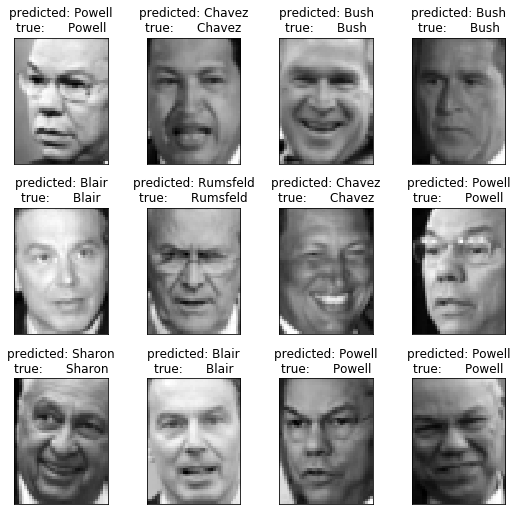

In [30]:
# 生成测试集中图片的title
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_predict, y_test, target_names, i)
                     for i in range(y_predict.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
pl.show()